## A brief review of backpropagation

Each neuron is defined by a bias $b$ a set of inputs $X_i$ and an associated weight $w_i$ for each input. 

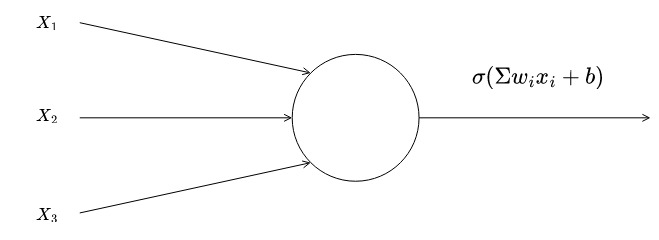

A single perceptron outputs  $ out = \sigma(z)$ where $$z = \Sigma w_i x_i + b$$

We call $z$ the weighted output of the neuron and $\sigma$ the activation function. The activation function introduces non-linearity to the model, allowing it to learn complex patterns and relationships in the data. In our example we use the sigmoid function.

If we dispose the perceptrons in layers, we can easily parallelize these computations using matrix operations. We address the parallelized quantities by an apex specifying the layer. For example $z^l$ means all the weighted outputs of the layer $l$. 

To assess the quality of our output we need to define a cost function. The cost function depends only on the current output, and intuitively provides the feedback that we need to propagate trough the network to improve the overall performance. We call the cost function $C$ and in our example we use the quadratic cost function. 

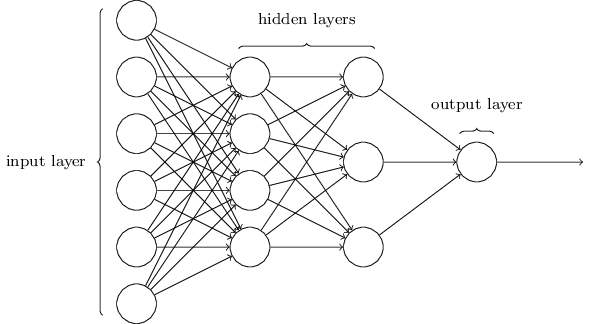

To better understand the backpropagation algorithm we define some supporting quantities. We define the activation $a^l$ for the layer l as:  
$$a^l = \sigma(z^l)$$
We can thus define the weighted output $z^l$ for a given layer as a function of weights, biases and activations of the previous layers :
$$ z^l = w^l a^{l-1} + b^l$$
Finally we introduce the error $\delta$, which for a specific neuron $j$ in layer $l$ is defined as:
$$\delta_j^{l} = \frac{\partial C}{\partial z_j^{l}}$$
which can be interpreted as the variation on the cost function caused by the weighted output of a neuron.

Now lets take a look at the actual backpropagation algorithm: 

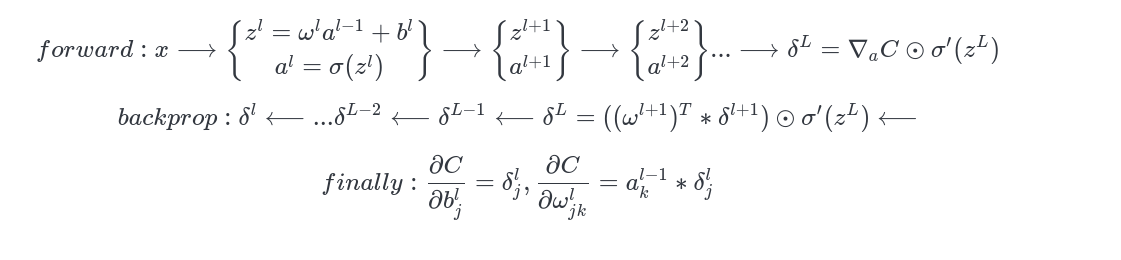

#### the algorithm can be summarized in :
1) Given the input calculate all the weighted outputs and activations for all the layers
2) Compute the error for the last layer 
3) Propagate backward by calculating the errors layer by layer
4) Finally calculate the variation of the cost with respect of bias and weights 
5) Use an optimization algorithm such as gradient descent to update bias end weights 

## Lets implement this algorithm
Testing our neural network with a classic classification task on a variation of the Mnist dataset called KMnist.  

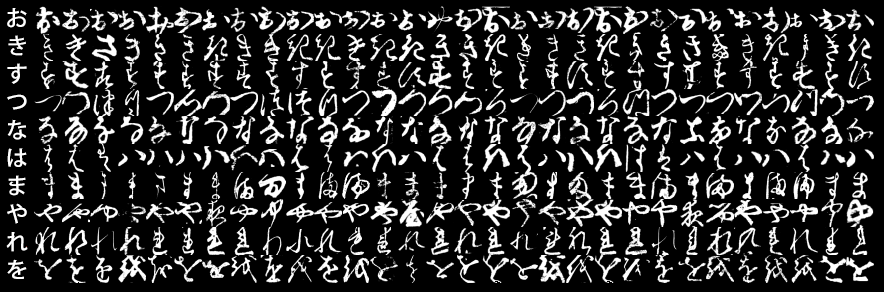

In [4]:
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#import loader
import time 
import copy
# Util for pwd 
import gzip
cwd = os.getcwd()
# Data needs to be normalized 
from sklearn.preprocessing import MinMaxScaler

### loading the dataset

In [6]:
#Produce the unit vector for the network 
def unit_vector(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e


def load_data(keras):
    #load data 
    test_imgs = np.load("./kmnist-test-imgs.npz")['arr_0']
    test_labels = np.load("./kmnist-test-labels.npz")['arr_0']
    train_imgs = np.load("./kmnist-train-imgs.npz")['arr_0']
    train_labels = np.load("./kmnist-train-labels.npz")['arr_0']
    
    #cast 
    test_imgs = test_imgs.astype("float32")
    train_imgs = train_imgs.astype("float32")
    test_labels = test_labels.astype("int64")
    train_labels = train_labels.astype("int64")

    if(keras == False):

        # Reshape so that the input is a single array of dimension 784 
        #(rather than 28x28)
        test_imgs = np.reshape(test_imgs,[10000,784])
        train_imgs = np.reshape(train_imgs,[60000,784])

        # Data is raw, normalization is necessary to avoid overflow with the sigmoid 
        scaler = MinMaxScaler(feature_range=(0,1))
        test_imgs = scaler.fit_transform(test_imgs)
        train_imgs = scaler.fit_transform(train_imgs)

        # Transform the data in a zip iterable object 
        training_inputs = [np.reshape(x,[784,1]) for x in train_imgs]
        training_results = [unit_vector(y) for y in train_labels]
        training_data = zip(training_inputs, training_results)
        test_inputs = [np.reshape(x, [784,1]) for x in test_imgs]
        test_data = zip(test_inputs, test_labels)

        return (list(training_data), list(test_data))

    else:
        return test_imgs,test_labels, train_imgs, train_labels



In [3]:
def set_biases(bias_matrix_dim,rnd):
    tmp = []
    for i in bias_matrix_dim:
        tmp.append(rnd.randn(i, 1))
    return tmp
    
def set_weights(weight_matrix_dim,rnd):
    tmp = []
    for i in weight_matrix_dim:
        tmp.append(rnd.randn(i[1], i[0]))
    return tmp

def set_weights_unsaturated(weight_matrix_dim,rnd):
    tmp = []
    for i in weight_matrix_dim:
        tmp.append(rnd.randn(i[1], i[0])/np.sqrt(i[0]))
    return tmp
    
def split_data(training_data,mini_batch_size): 
    tmp = []
    for i in range(0,len(training_data),mini_batch_size):
        tmp.append(training_data[i:i+mini_batch_size])
    return tmp

def prepare_weightMatrix_dim(sizes):
    tmp = []
    for i in range(len(sizes)-1):
        tmp.append([sizes[i],sizes[i+1]])
    return tmp

In [4]:
# PARAMETERS SETTING 
#Set network architecture
sizes = [784,28,28,10]
#Set if unsaturated weights
unsaturated_weights = True
epochs = [18,18]
mini_batches_len = [100,100]
eta = [0.6,0.6]
cross_entropy = [True,False]
L2_regularization = [True,False]

In [5]:
def train(training_data, epochs, mini_batch_size, eta,test_data,weights,biases,rnd,plot=True,L2=True,cross_entropy=False):
        
        # Start time, timestamps for tuning purposes 
        start = time.time()
        train_evaluation = []
        timestamps =  []
        #Setup of logs for visualization purposes 
        biases_log = []
        weights_log = []

        n_test = len(test_data)
	    # cycle trough the requested number of epochs 
        for i in range(epochs):
	        # Shuffle the training data, so to achieve random batches
            rnd.shuffle(training_data)
	        # split the data in batches
            mini_batches = split_data(training_data, mini_batch_size)
            print("mini batches number : ", len(mini_batches))
            
            # SGD
	        # Update paramenters for each mini batch
            for mini_batch in mini_batches:
            		
            		# Prepare the lists for the partial derivatives of weights and biases
                    partial_deriv_biases = [np.zeros_like(b) for b in biases]
                    partial_deriv_weights = [np.zeros_like(w) for w in weights]

            		# for each training example run trough the network
                    for x, y in mini_batch:
            		    # we obtain from the network the two vectors 
            		    # containing the partial derivatives with respect to weight and bias
                        deriv_bias, deriv_weight = backprop(x, y,biases,weights,cross_entropy)
            		    #sum the values
                        for l in range(len(partial_deriv_biases)):
                            partial_deriv_biases[l] = partial_deriv_biases[l] + deriv_bias[l]
                        for l in range(len(partial_deriv_weights)):
                            partial_deriv_weights[l] = partial_deriv_weights[l] + deriv_weight[l]
                        
            		# finally compute the updated values of weights and biases         
                    # Optional L2 regularization 
                    if(L2==True):
                        # L2 reg parameter
                        lambda_ = 4
                        for l in range(len(weights)):
                            weights[l] = ((1-(lambda_/len(training_data))) * weights[l]) - (eta/len(mini_batch))*partial_deriv_weights[l]
                    else:
                        for l in range(len(weights)):
                            weights[l] = weights[l] - (eta/len(mini_batch))*partial_deriv_weights[l]

                    for l in range(len(biases)):
                            biases[l] = biases[l] - (eta/len(mini_batch))*partial_deriv_biases[l]

            
            # time evaluation
            timestamps.append(time.time() - start)
            
            #Get current net performance 
            v = evaluation(test_data,biases,weights)
            print("{0} --> correct classifications: ({1} / {2}) ".format(
                i, v, n_test))
            # update the train evaluation list 
            train_evaluation.append(v)

                
            # Following commands for plotting 
            if(plot==True):
                level = 1 # choose which level of the network to plot 
                biases_log.append(biases[level])
                weights_log.append(weights[level])
        
        return train_evaluation, timestamps, biases_log, weights_log


In [6]:
def backprop(net_input, y,biases,weights,cross_entropy):
    
        a = [] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        
	    # Two empty vectors carrying the result 
        deriv_bias = [np.zeros_like(b) for b in biases]
        deriv_weight = [np.zeros_like(w) for w in weights]
        
        a.append(net_input)
        # FORWARD RUN
        # Iteration trough the layers, everything computed in vector form
        for b, w in zip(biases, weights):
    
	    #compute each intermediate value z
            z = np.dot(w, net_input)+b
	    #save it for later 
            zs.append(z)
	    #calculate and store each activation value 
            net_input = sigmoid(z)
            a.append(net_input)
        # backward run trough the network 
	    # calculate the first delta 
        if(cross_entropy == True):
            delta = crosscost_derivarive(a[-1], y,zs[-1]) 
        else:
            delta = quadcost_derivative(a[-1], y,zs[-1]) 
            
        deriv_bias[-1] = delta
        deriv_weight[-1] = np.dot(delta, a[-2].transpose())
        #BACKWARD RUN 
        for l in range(-2, -len(sizes),-1):
            z = zs[l]
            sigma_prime = sigmoid_deriv(z)
	    # calculate current delta 
        # Hadamard product *
            delta = np.dot(weights[l+1].transpose(), delta) * sigma_prime
	    # calculate each value for bias and weight, as in (BP3/4)
            deriv_bias[l] = delta
            deriv_weight[l] = np.dot(delta, a[l-1].transpose())
	    #return the two vectors 
        return (deriv_bias, deriv_weight)

def quadcost_derivative(output_activations, y,z):
        return ((output_activations-y) * sigmoid_deriv(z))
    
def crosscost_derivarive(output_activations, y,z):
        #Simply remove the sigmoid term
        return (output_activations-y) 

def evaluation(test_data,biases,weights):
        tmp = []
        results = []
        # we get the output for every test input
        for x,y in test_data:
            results.append((net_output(x,biases,weights),y))
        for i in results:
            # Argmax for finding the most likely result 
            tmp.append((np.argmax(i[0]),i[1]))
        correct_classifications = 0
        for (x,y) in tmp:
            if(int(x)==int(y)):
                correct_classifications = correct_classifications + 1
        return correct_classifications
    
def net_output(net_input,biases,weights):
	#Forward pass in the network 
    # get current output given input (evaluation purposes)    
    for i in range(len(weights)):
        current_z = np.dot(weights[i],net_input) + biases[i]
        net_input = sigmoid(current_z)
    return net_input

def sigmoid(z):
    try:
        return 1.0/(1.0+np.exp(-z))
    except:
        # Overflow check 
        print(z)
    
def sigmoid_deriv(z):
    return sigmoid(z)*(1-sigmoid(z))


In [ ]:
num_layers = len(sizes)
# Prepare biases for each level except the first 
bias_matrix_dim = sizes[1:]
# Prepare weights 
weight_matrix_dim = prepare_weightMatrix_dim(sizes)

print("bias matrix dim", bias_matrix_dim)
print("weight matrix dim",weight_matrix_dim)

rnd = np.random.RandomState(121)

biases = set_biases(bias_matrix_dim,copy.deepcopy(rnd))
# Using the unsaturated version dramatically improves the first stages of learning
if(unsaturated_weights==True):
    weights = set_weights_unsaturated(weight_matrix_dim,copy.deepcopy(rnd))
else:
    weights = set_weights(weight_matrix_dim,copy.deepcopy(rnd))

train_evaluation = []
timestamps = []
train_evaluation2 = []
timestamps2 = []

# Load the data, as zip iterables 
training_data, test_data = load_data(False)

# Set error so to be reactive to overflow 
np.seterr(all='print')

# Call the two train methods 
train_evaluation,timestamps, biases_log, weights_log = train(copy.deepcopy(training_data), epochs[0], mini_batches_len[0], eta[0],
                                    copy.deepcopy(test_data),copy.deepcopy(weights),copy.deepcopy(biases),copy.deepcopy(rnd),
                                    L2=L2_regularization[0],
                                    cross_entropy=cross_entropy[0])


bias matrix dim [28, 28, 10]
weight matrix dim [[784, 28], [28, 28], [28, 10]]
mini batches number :  600
0 --> correct classifications: (6841 / 10000) 
mini batches number :  600
1 --> correct classifications: (7418 / 10000) 
mini batches number :  600
2 --> correct classifications: (7734 / 10000) 
mini batches number :  600
3 --> correct classifications: (7910 / 10000) 
mini batches number :  600
4 --> correct classifications: (7915 / 10000) 
mini batches number :  600
5 --> correct classifications: (7925 / 10000) 
mini batches number :  600
6 --> correct classifications: (8110 / 10000) 
mini batches number :  600


In [ ]:
%matplotlib inline
num_images = len(weights_log)
image_data = weights_log

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(image_data[0], animated=True)

def update(frame):
    im.set_array(image_data[frame])
    return im,

ani = FuncAnimation(fig, update, frames=range(num_images), repeat=True)
plt.close()
# Display the animation
HTML(ani.to_jshtml())

In [55]:
%matplotlib inline
num_images = len(biases_log)
image_data = biases_log

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(image_data[0], animated=True)

def update(frame):
    im.set_array(image_data[frame])
    return im,

ani = FuncAnimation(fig, update, frames=range(num_images), repeat=True)
plt.close()
# Display the animation
HTML(ani.to_jshtml())

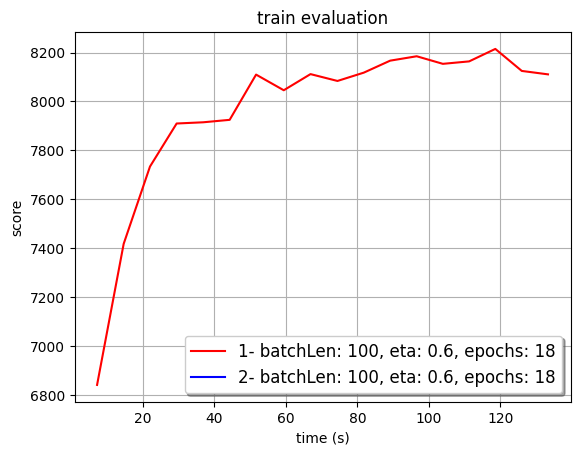

In [16]:
# Plot a train evaluation
fig2, ax = plt.subplots()
ax.plot(timestamps,train_evaluation,color="red",label="1- batchLen: {0}, eta: {1}, epochs: {2}".format(mini_batches_len[0],eta[0],epochs[0]))
ax.plot(timestamps2,train_evaluation2,color="blue",label="2- batchLen: {0}, eta: {1}, epochs: {2}".format(mini_batches_len[1],eta[1],epochs[1]))
ax.set(xlabel='time (s)', ylabel='score',
       title='train evaluation')
ax.grid()
ax.legend(shadow=True, fontsize="large")

plt.show()

# Now lets do it with TF/Keras

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-09-11 12:09:32.785346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 12:09:32.821166: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-11 12:09:33.578520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-11 12:09:33.591210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] suc

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
x_test, y_test,x_train, y_train = load_data(True)
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [8]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1600)             

In [ ]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/15


2023-09-11 12:10:26.891534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-09-11 12:10:27.242986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-11 12:10:27.244222: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x563dcdca3c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-11 12:10:27.244234: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2023-09-11 12:10:27.247146: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-11 12:10:27.307788: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

422/422 [==============================] - 4s 5ms/step - loss: 0.6792 - accuracy: 0.7902 - val_loss: 0.2837 - val_accuracy: 0.9183
Epoch 2/15
422/422 [==============================] - 3s 6ms/step - loss: 0.3106 - accuracy: 0.9069 - val_loss: 0.2020 - val_accuracy: 0.9427
Epoch 3/15
422/422 [==============================] - 3s 6ms/step - loss: 0.2391 - accuracy: 0.9268 - val_loss: 0.1534 - val_accuracy: 0.9545
Epoch 4/15
422/422 [==============================] - 2s 5ms/step - loss: 0.2043 - accuracy: 0.9383 - val_loss: 0.1305 - val_accuracy: 0.9625
Epoch 5/15
422/422 [==============================] - 2s 5ms/step - loss: 0.1764 - accuracy: 0.9471 - val_loss: 0.1155 - val_accuracy: 0.9655
Epoch 6/15
422/422 [==============================] - 3s 6ms/step - loss: 0.1592 - accuracy: 0.9510 - val_loss: 0.1107 - val_accuracy: 0.9693
Epoch 7/15
422/422 [==============================] - 2s 6ms/step - loss: 0.1474 - accuracy: 0.9547 - val_loss: 0.0993 - val_accuracy: 0.9708
Epoch 8/15
422/42

In [7]:
def plot_keras_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # If accuracy is being tracked, then plot it as well
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

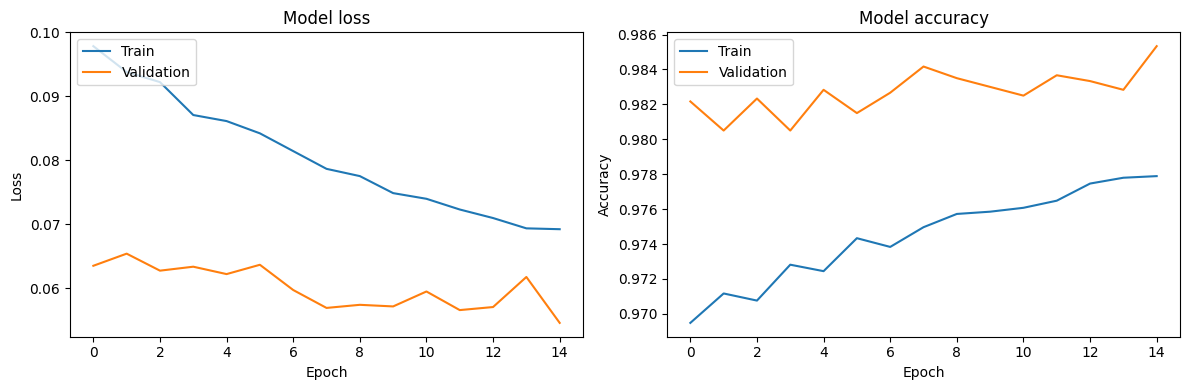

In [53]:
plot_keras_history(history)